# Modelo Baseline para NER que entrena una Backpropagation y tiene como conjunto de extrenamiento (X,y), el token de la palabra y el label desde el corpus Conll2002.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%pip install sklearn-crfsuite
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [4]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
eval_sents = list(nltk.corpus.conll2002.iob_sents('esp.testa'))
print(len(train_sents),len(max(train_sents,key=len)))
print(len(test_sents),len(max(test_sents,key=len)))
print(len(eval_sents),len(max(eval_sents,key=len)))

8323 1238
1517 202
1915 141
CPU times: user 1.78 s, sys: 72.2 ms, total: 1.85 s
Wall time: 1.86 s


In [5]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

# PARTE  1. PREPROCESAMIENTO DE LOS DATOS

In [6]:
def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [7]:
sent2tokens(train_sents[0])[0]
#sent2labels(train_sents[0])[0]

'Melbourne'

In [8]:
%%time
X_train = [sent2tokens(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2tokens(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

X_eval = [sent2tokens(s) for s in eval_sents]
y_eval = [sent2labels(s) for s in eval_sents]

CPU times: user 120 ms, sys: 4.94 ms, total: 125 ms
Wall time: 125 ms


In [9]:
print(X_train[2])
print(y_train[2])

['El', 'Abogado', 'General', 'del', 'Estado', ',', 'Daryl', 'Williams', ',', 'subrayó', 'hoy', 'la', 'necesidad', 'de', 'tomar', 'medidas', 'para', 'proteger', 'al', 'sistema', 'judicial', 'australiano', 'frente', 'a', 'una', 'página', 'de', 'internet', 'que', 'imposibilita', 'el', 'cumplimiento', 'de', 'los', 'principios', 'básicos', 'de', 'la', 'Ley', '.']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O']


In [10]:
import numpy as np

words, tagsss = set([]), set([])
 
for s in (X_train + X_eval + X_test):
    for w in s:
        words.add(w.lower())

for ts in (y_train + y_eval + y_test):
    for t in ts:
        tagsss.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 2 for i, t in enumerate(list(tagsss))}
tag2index['-PAD-'] = 0  # The special value used to padding
tag2index['-OOV-'] = 1  # The special value used to padding

print (len(word2index))
print (len(tag2index))

np.save('vectors/word2index.npy', word2index)
np.save('vectors/tag2index.npy', tag2index)

28384
11


In [11]:
train_sentences_X, eval_sentences_X, test_sentences_X, train_tags_y, eval_tags_y, test_tags_y = [], [], [], [], [], []

for s in X_train:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)

for s in X_eval:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    eval_sentences_X.append(s_int)

for s in X_test:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)

for s in y_train:
    s_int = []
    for w in s:
        try:
            s_int.append(tag2index[w])
        except KeyError:
            s_int.append(tag2index['-OOV-'])
            
    train_tags_y.append(s_int)

for s in y_eval:
    s_int = []
    for w in s:
        try:
            s_int.append(tag2index[w])
        except KeyError:
            s_int.append(tag2index['-OOV-'])
            
    eval_tags_y.append(s_int)

for s in y_test:
    s_int = []
    for w in s:
        try:
            s_int.append(tag2index[w])
        except KeyError:
            s_int.append(tag2index['-OOV-'])
            
    test_tags_y.append(s_int)


Las matrices de los tags son de números indexados pequeños porque solo son 11 tags.  (ORG, LOC, PER, IOB)

In [12]:
print("Longitudes de las Matrices:")
print(len(train_sentences_X))
print(len(eval_sentences_X))
print(len( test_sentences_X))
print(len(train_tags_y))
print(len(eval_tags_y))
print(len(test_tags_y))

print("\nMuestra de Datos presentes en las Matrices con las transformaciones:\n")


print(train_sentences_X[0])
print(eval_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(eval_tags_y[0])
print(test_tags_y[0])


Longitudes de las Matrices:
8323
1915
1517
8323
1915
1517

Muestra de Datos presentes en las Matrices con las transformaciones:

[27925, 14239, 7509, 8916, 19669, 17809, 26072, 14239, 11784, 8916, 4116]
[10107, 10088, 14239, 11459, 8916, 19669, 20757, 26072, 14239, 23195, 8916, 4116]
[21896, 12252, 19669, 20757, 26072, 14239, 23195, 8916, 4116]
[8, 10, 8, 10, 10, 10, 10, 10, 6, 10, 10]
[8, 3, 10, 8, 10, 10, 10, 10, 10, 6, 10, 10]
[8, 3, 10, 10, 10, 10, 6, 10, 10]


In [13]:
MAX_LENGTH1 = len(max(train_sentences_X, key=len))
MAX_LENGTH2 = len(max(eval_sentences_X, key=len))
MAX_LENGTH3 = len(max(test_sentences_X, key=len))

l = [MAX_LENGTH1, MAX_LENGTH2, MAX_LENGTH3]
MAX_LENGTH = max(l)

print(MAX_LENGTH)

1238


Se procede a Normalizar las matrices para que todas contengan el mismo numero de columans, con la longitud maxima de palabras encontradas anteriormente, esto se logra agregando ceros a la derecha en las posiciones que hacen falta en el vector¶

In [14]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
eval_sentences_X = pad_sequences(eval_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
eval_tags_y = pad_sequences(eval_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences_X[0])
print(eval_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(eval_tags_y[0])
print(test_tags_y[0])

np.save('vectors/train_sentences_X.npy', train_sentences_X)
np.save('vectors/eval_sentences_X.npy', eval_sentences_X)
np.save('vectors/test_sentences_X.npy', test_sentences_X)
np.save('vectors/train_tags_y.npy', train_tags_y)
np.save('vectors/eval_tags_y.npy', eval_tags_y)
np.save('vectors/test_tags_y.npy', test_tags_y)

Using TensorFlow backend.


[27925 14239  7509 ...     0     0     0]
[10107 10088 14239 ...     0     0     0]
[21896 12252 19669 ...     0     0     0]
[ 8 10  8 ...  0  0  0]
[ 8  3 10 ...  0  0  0]
[ 8  3 10 ...  0  0  0]


In [15]:
def to_categoricals(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [16]:
import numpy as np
from keras.utils import to_categorical

def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

Se realiza la categorización one-hot de las etiquetas

In [17]:
cat_train_tags_y = to_categoricals(train_tags_y, len(tag2index))
cat_eval_tags_y  = to_categoricals(eval_tags_y, len(tag2index))
cat_test_tags_y  = to_categoricals(test_tags_y, len(tag2index))

print(cat_train_tags_y[0])
print(len(cat_train_tags_y))
print(len(cat_test_tags_y))

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
8323
1517


# PARTE 2. ENTRENAMIENTO DEL MODELO DE RED.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1238, 128)         3633152   
_________________________________________________________________
activation_1 (Activation)    (None, 1238, 128)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 1238, 11)          1419      
_________________________________________________________________
activation_2 (Activation)    (None, 1238, 11)          0         
Total params: 3,634,571
Trainable params: 3,634,571
Non-trainable params: 0
_________________________________________________________________


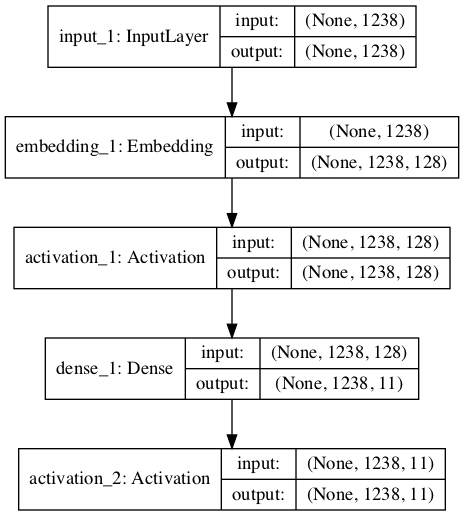

In [18]:
!pip install pydot
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Embedding, Activation
from keras.optimizers import Adam
from keras.utils import plot_model

model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Activation('relu'))
model.add(Dense(len(tag2index)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
 
model.summary()

plot_model(model, to_file='Plot/model/model-mb00.png', show_shapes=True)

In [19]:
#sudo pip install h5py
import os
model_hist = model.fit(train_sentences_X, cat_train_tags_y,
                       validation_data=(eval_sentences_X, cat_eval_tags_y),
                       batch_size=128, 
                       epochs=20,
                       validation_split=0.2)

# serialize model to JSON
model_json = model.to_json()
with open("model/mb-00.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model/mb-00.h5")
print("Saved model to disk")

/Users/raulernestogutierrezdepinerezreyes/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8323 samples, validate on 1915 samples
Epoch 1/20
8323/8323 [==============================] - 37s 4ms/step - loss: 1.8891 - accuracy: 0.9895 - val_loss: 1.2973 - val_accuracy: 0.9927
Epoch 2/20
8323/8323 [==============================] - 52s 6ms/step - loss: 0.7189 - accuracy: 0.9933 - val_loss: 0.2813 - val_accuracy: 0.9945
Epoch 3/20
8323/8323 [==============================] - 44s 5ms/step - loss: 0.1621 - accuracy: 0.9955 - val_loss: 0.0899 - val_accuracy: 0.9957
Epoch 4/20
8323/8323 [==============================] - 44s 5ms/step - loss: 0.0677 - accuracy: 0.9967 - val_loss: 0.0496 - val_accuracy: 0.9961
Epoch 5/20
8323/8323 [==============================] - 45s 5ms/step - loss: 0.0415 - accuracy: 0.9970 - val_loss: 0.0344 - val_accuracy: 0.9964
Epoch 6/20
8323/8323 [==============================] - 53s 6ms/step - loss: 0.0301 - accuracy: 0.9971 - val_loss: 0.0268 - val_accuracy: 0.9966
Epoch 7/20
8323/8323 [==============================] - 45s 5ms/step - loss: 0.023

# Función que Permite convertir Indices en Tags

In [20]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

# Hacemos la prediccion sobre el conjunto de pruebas. De la distribución probabilítica a etiquetas. 

In [22]:
import pandas as pd

prediction = model.predict(test_sentences_X)
log_tokens = logits_to_tokens(prediction, {i: t for t, i in tag2index.items()})

print(log_tokens[0])

['O', '-PAD-', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '

In [23]:
test_samples = [
    "Correr en Colombia con James Rodriguez .".split(),
    "Éste gran hombre ganó con el Real Madrid de España y en Alemania con Roler.".split()
]
#print(max(test_samples))
print(test_samples)

[['Correr', 'en', 'Colombia', 'con', 'James', 'Rodriguez', '.'], ['Éste', 'gran', 'hombre', 'ganó', 'con', 'el', 'Real', 'Madrid', 'de', 'España', 'y', 'en', 'Alemania', 'con', 'Roler.']]


# Convertimos el texto en Una entrada para el Modelo y se generan los dos vecores de enteros de las dos oraciones.

In [24]:
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)

test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)
print(test_samples_X.shape)

[[17399 13135 23744 ...     0     0     0]
 [13635 23259 15098 ...     0     0     0]]
(2, 1238)


# Se Ejecuta la predicion con la Entrada del modelo entrenado y el modelo de la red neuronal predice un matriz de 1238 X 11 por cada oración. El shape de a predicción es (2, 1238,11)¶ 

In [25]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

[[[7.99840875e-03 3.90247069e-03 1.41719356e-02 ... 8.20799544e-03
   1.24211311e-02 9.04784501e-01]
  [3.24918801e-04 1.38846226e-04 9.44528962e-04 ... 3.18266219e-04
   1.30565069e-03 9.95768428e-01]
  [1.74604729e-02 6.27770042e-03 6.97574988e-02 ... 6.82839870e-01
   2.03324817e-02 8.50195438e-02]
  ...
  [9.98931825e-01 1.05626212e-04 9.85615479e-05 ... 9.54181378e-05
   1.22234778e-04 1.14075163e-04]
  [9.98931825e-01 1.05626212e-04 9.85615479e-05 ... 9.54181378e-05
   1.22234778e-04 1.14075163e-04]
  [9.98931825e-01 1.05626110e-04 9.85613588e-05 ... 9.54180505e-05
   1.22234662e-04 1.14074945e-04]]

 [[3.73800314e-04 1.92041465e-04 7.81480339e-04 ... 2.38491280e-04
   1.48972217e-03 9.93980646e-01]
  [1.24924127e-02 1.02932509e-02 3.84277962e-02 ... 2.50350032e-02
   3.41972709e-02 7.97256529e-01]
  [2.27157725e-03 1.06526294e-03 5.48004592e-03 ... 2.72157928e-03
   6.55162567e-03 9.71248806e-01]
  ...
  [9.98931825e-01 1.05626212e-04 9.85615479e-05 ... 9.54181378e-05
   1.22234

In [26]:
#print(len(predictions))
log_tokens = logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})
print(log_tokens)

[['O', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '

In [27]:
#!pip install tabulate
from tabulate import tabulate

heads1 = test_samples[0]
body1 = [log_tokens[0][:len(test_samples[0])]]

heads2 = test_samples[1]
body2 = [log_tokens[1][:len(test_samples[1])]]

print(tabulate(body1, headers=heads1))

print ("\n")

print(tabulate(body2, headers=heads2))


## postagging Freeling 4.1

## El      hombre   bajo     corre    bajo  el      puente   con  bajo  índice   de  adrenalina  .
## DA0MS0  NCMS000  AQ0MS00  VMIP3S0  SP    DA0MS0  NCMS000  SP   SP    NCMS000  SP  NCFS000     Fp


## pos tagger Stanford NLP

## El      hombre   bajo     corre    bajo  el      puente   con    bajo   índice  de    adrenalina  .
## da0000  nc0s000  aq0000   vmip000  sp000 da0000  nc0s000  sp000  aq0000 nc0s000 sp000 nc0s000     fp

Correr    en    Colombia    con    James    Rodriguez    .
--------  ----  ----------  -----  -------  -----------  ---
O         O     B-LOC       O      B-PER    O            O


Éste    gran    hombre    ganó    con    el    Real    Madrid    de    España    y    en    Alemania    con    Roler.
------  ------  --------  ------  -----  ----  ------  --------  ----  --------  ---  ----  ----------  -----  --------
O       O       O         O       O      O     B-ORG   B-LOC     O     B-LOC     O    O     B-LOC       O      O
